# Dog Breed Image Classification

**Data Scientist** : Anhduy Nguyen

**Date** July 7, 2022

### Stake Holder

- American Society for the Prevention of Cruelty to Animals(ASPCA)

### Business Understanding

The ASPCA has informed us that over 6.5 million animals are taken into US shelters annualy, which 3.3 million of those are dogs.  Only around 50% of the sheltered animals are adopted, 20-30% are euthanized, while the remaining stay in the shelters.

### Business Problem

This task at hand is to build a image classification system utilizing pictures of 120 breeds of dogs to classify incoming strays into their breed category.  This will help identify each incoming stray and decrease the workload on the volunteers and workers at animal shelters.  By labeling each stray it will help potential adopters search for the specific dog breed they want or the ability to research the temperament and overall information about raising the specific dog breed before their adoption.

### Data Understanding

The data was retrieved from the Stanford Dog Dataset. The data can be retrieved from (http://vision.stanford.edu/aditya86/ImageNetDogs/), but also has been linked at Kaggle.com(https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset).  There are around 20580 images split into 120 different breeds.  The images were precleaned only retaining adult image of dogs and only images that had a greater than 200 x 200 pixel size.

## Import Libraries

In [1]:
import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
import seaborn as sns
import gc
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import warnings
warnings.filterwarnings('ignore')


from numpy.random import seed
seed(42)

import os
import tqdm
from os import walk
from itertools import chain
import random

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import BatchNormalization


import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import BatchNormalization
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.initializers import RandomNormal
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
import pathlib
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

from tensorflow.keras.optimizers import Adam, RMSprop

import re

## 1 Data Preparation

The data has already been split into the different dog breed previously a 120 in total and the only data preparation that needs to be done are splitting the data into the Train and Validation/Test sets.

### 1.A Pulling in the Data into Train and Test Sets

In [3]:
# Importing Train and Test/Validation Set

train_ds = tf.keras.preprocessing.image_dataset_from_directory('Data/images/Images/', validation_split = .2, subset= 'training',
                                                      seed = 42, image_size = (299,299),
                                                      batch_size = 32)

test_ds = tf.keras.preprocessing.image_dataset_from_directory('Data/images/Images/', validation_split = .2, subset= 'validation',
                                                      seed = 42, image_size = (299,299),
                                                      batch_size = 32)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [4]:
# Showing the Shape of the data

print("Train Shape", train_ds)

print("Test Shape", test_ds)

Train Shape <BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.int32)>
Test Shape <BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.int32)>


- As shown above the images are split into the training set which contains 16464 images and the test set which is 4116 images.  The shapes of the data is 299, 299, 3.  Which represents 299 x 299 pixels and 3 which represents rgb.

- Due to the Image classification needing a large amount of data to train a good model we will be augmenting our data set by shifting, rotating, and flipping the images.

### 1. B Data Augmentation

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal",
                                                     input_shape=(299,
                                                                 299,
                                                                 3)),
        layers.experimental.preprocessing.RandomRotation(.4),
        layers.experimental.preprocessing.RandomZoom(.2),
    ]
)

In [6]:
# The augmentation being done on the data

data_augmentation_transfer = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal",
                                                     input_shape=(299,
                                                                 299,
                                                                 3)),
        layers.experimental.preprocessing.RandomRotation(.4),
        layers.experimental.preprocessing.RandomWidth(.2),
        layers.experimental.preprocessing.RandomHeight(.2),
        layers.experimental.preprocessing.RandomZoom(.2),
    ]
)

### 1. C Creating Target Variables

In [7]:
# Creating target variables which are the 120 breed names

# Fix class names by removing number identifier and -
class_names = train_ds.class_names
print(class_names)
dog_names = [word for line in class_names for word in re.split('0-|1-|2-|3-|4-|5-|6-|7-|8-|9-', line)]

# Making another list for cleaned names
print([i for i in range(len(dog_names)) if i % 2 == 1])

dog_names2 =[]
for i in range(len(dog_names)):
        if i % 2 == 1:
            dog_names2.append(dog_names[i])

['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433-Yorkshire_t

In [8]:
# Sanity Check the label names

dog_names2

['Chihuahua',
 'Japanese_spaniel',
 'Maltese_dog',
 'Pekinese',
 'Shih-Tzu',
 'Blenheim_spaniel',
 'papillon',
 'toy_terrier',
 'Rhodesian_ridgeback',
 'Afghan_hound',
 'basset',
 'beagle',
 'bloodhound',
 'bluetick',
 'black-and-tan_coonhound',
 'Walker_hound',
 'English_foxhound',
 'redbone',
 'borzoi',
 'Irish_wolfhound',
 'Italian_greyhound',
 'whippet',
 'Ibizan_hound',
 'Norwegian_elkhound',
 'otterhound',
 'Saluki',
 'Scottish_deerhound',
 'Weimaraner',
 'Staffordshire_bullterrier',
 'American_Staffordshire_terrier',
 'Bedlington_terrier',
 'Border_terrier',
 'Kerry_blue_terrier',
 'Irish_terrier',
 'Norfolk_terrier',
 'Norwich_terrier',
 'Yorkshire_terrier',
 'wire-haired_fox_terrier',
 'Lakeland_terrier',
 'Sealyham_terrier',
 'Airedale',
 'cairn',
 'Australian_terrier',
 'Dandie_Dinmont',
 'Boston_bull',
 'miniature_schnauzer',
 'giant_schnauzer',
 'standard_schnauzer',
 'Scotch_terrier',
 'Tibetan_terrier',
 'silky_terrier',
 'soft-coated_wheaten_terrier',
 'West_Highland_wh

### 1. D Showing Images of the Dogs

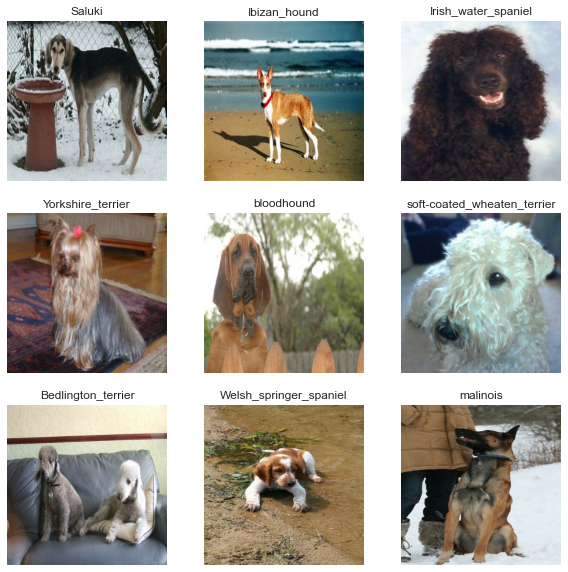

In [9]:
# Sample showing dog and dog name

import matplotlib.pyplot as plt

sns.set_style("white")

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(dog_names2[labels[i]])
    plt.axis("off")
    plt.savefig('Images/DogImages.png', bbox_inches = "tight")
plt.show()


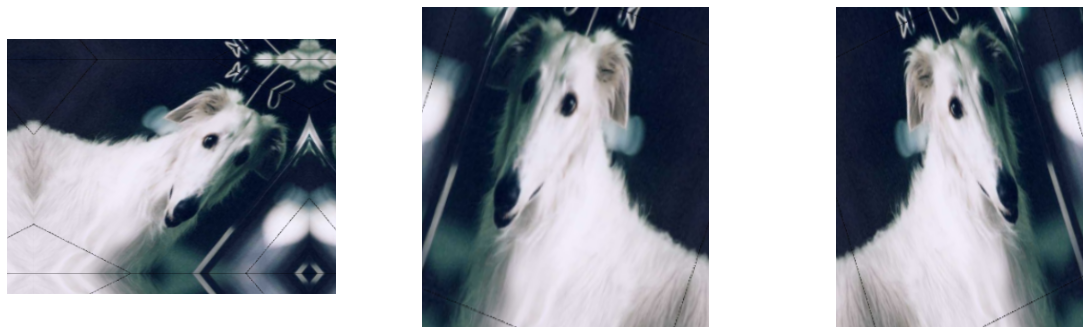

In [17]:
## Showing Images with Data Augmentation

plt.figure(figsize=(20, 20))
for images, _ in train_ds.take(1):
  for i in range(3):
    augmented_images = data_augmentation_transfer(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
    plt.savefig('Images/DogImagesAugmentation.png', bbox_inches = "tight")
plt.show()

## 2 Modeling

### 2. A Base Model

In [10]:
# Base Model without data augmentation

num_classes = len(dog_names2)

model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(299, 299, 3)))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(len(dog_names2)))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

history = model.fit(
    train_ds,
    epochs = 10, 
    validation_data = test_ds)

print(f"\nTraining Score: {model.evaluate(train_ds)}")
print(f"\nTest Score: {model.evaluate(test_ds)}")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 299, 299, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 299, 299, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 149, 149, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)       

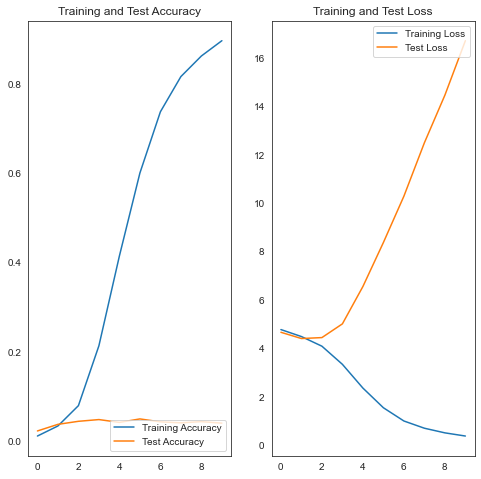

<Figure size 432x288 with 0 Axes>

In [11]:
## Graphing Base Model
# Accidentally switched to MD will run later

acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

loss = history.history['loss']
test_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, test_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, test_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Test Loss')
plt.show()
plt.savefig('Images/BaseModel.png', bbox_inches = "tight")

- It looks like the model is severly overfitting, Adding Data Augmentation and Dropout to reduce variance

### 2. B 2nd Model

In [12]:
# 2nd Model with Data Augmentation and Dropout

model = Sequential()
model.add(data_augmentation)
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(299, 299, 3)))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

history = model.fit(
    train_ds,
    epochs = 15, 
    validation_data= test_ds)


print(f"\nTraining Score: {model.evaluate(train_ds)}")
print(f"\nTest Score: {model.evaluate(test_ds)}")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 299, 299, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 299, 299, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 299, 299, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 149, 149, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 74, 74, 64)       

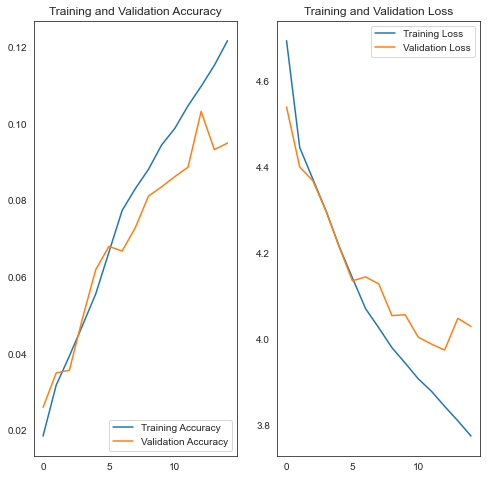

<Figure size 432x288 with 0 Axes>

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('Images/2ndModel.png', bbox_inches = "tight")

- We have solved the overfitting problem but the model training score has dropped alot, but its test score has increased by 5%
- Lets add Batch Normalization to see if there is and increase in the score

### 2. C 3rd Model

In [14]:
# Add Batch Normalization for 3rd Model

model = Sequential()
model.add(data_augmentation)
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(299, 299, 3)))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

history = model.fit(
    train_ds,
    epochs = 10, 
    validation_data= test_ds)


print(f"\nTraining Score: {model.evaluate(train_ds)}")
print(f"\nTest Score: {model.evaluate(test_ds)}")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 299, 299, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 299, 299, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 299, 299, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 299, 299, 16)      64        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 149, 149, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 149, 149, 32)     

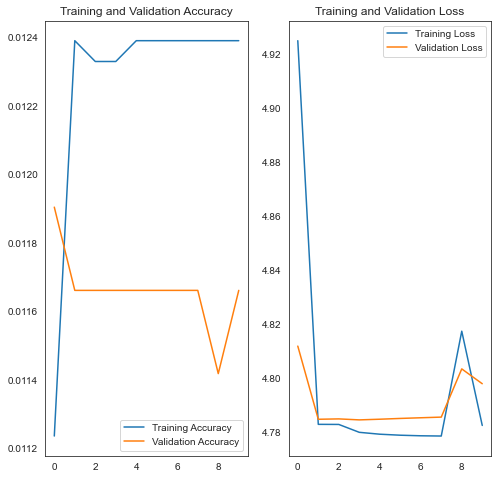

<Figure size 432x288 with 0 Axes>

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('Images/3rdModel.png', bbox_inches = "tight")

- Batch Normalization actually made the model worst 
- Seems classifying 120 targets can't be solved utilizing  a brand new model will attempt with Transfer Learning

## 3 Transfer Learning

In [16]:
# Adding a Transfer learning model known as InceptionV3 wwhich is known for image classification

pre_trained_model =  InceptionV3(weights = "imagenet", input_shape=(299,299,3), include_top= False)

for layer in pre_trained_model.layers:
    layer.trainable=False
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 149, 149, 32) 96          conv2d_9[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization_3[0][0]      
_______________________________________________________________________________________

In [17]:
# Using the ninth layer of the Model as input for our Transfer Learning model

last_layer = pre_trained_model.get_layer('mixed9')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 8, 8, 2048)


In [18]:
#  Creating a Callback stopping point for our model to cancell training when reaching 80% Target point

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.80):
      print("\nReached 80.0% accuracy so cancelling training!")
      self.model.stop_training = True

In [34]:
# Tranfer Learning Model

model = Sequential()
model.add(data_augmentation_transfer)
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(299, 299, 3)))
model.add(pre_trained_model)
model.add(GlobalAveragePooling2D())
model.add(layers.Flatten()) 
model.add(layers.Dropout(0.3))
model.add(Dense(2048, activation = 'relu'))
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(len(dog_names2), activation = 'softmax'))

model.compile(optimizer = RMSprop(lr=0.001), loss ='sparse_categorical_crossentropy', metrics =['accuracy'])

model.summary()

callbacks = myCallback()

history = model.fit(
    train_ds,
    epochs = 40,
    validation_data = test_ds,
    callbacks = [callbacks]
)

print(f"\nTraining Score: {model.evaluate(train_ds)}")
print(f"\nTest Score: {model.evaluate(test_ds)}")

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 2048)             

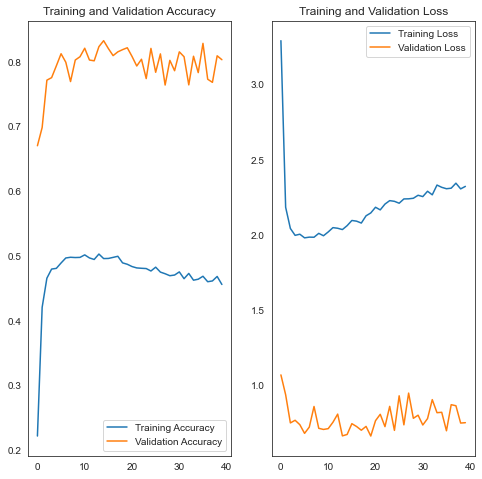

<Figure size 432x288 with 0 Axes>

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('Images/FinalModel.png', bbox_inches = "tight")

- Looks like the model performs well with around 80% accuracy for both the Training and Testing set when running .evaluate(), but seems like the model is severly underfitting by around 30% during the model training.  The output accuracy is 80%, but the average model training accuracy plateau's around 50% will have to do more research into the topic for an answer, but the model performs decently on tests

## 3. B Prediction Samples

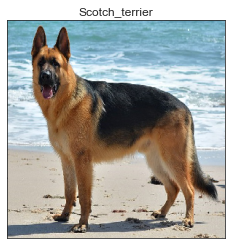

In [36]:
# importing images to test

img_path = ("TestImages/German_Shepherd.jpg")

img = image.load_img(img_path, target_size=(299, 299))

img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

img_preprocessed = preprocess_input(img_batch)

plt.imshow(img)
plt.title(dog_names2[np.argmax(model.predict(img_preprocessed))])
plt.xticks([])
plt.yticks([])
plt.savefig('Images/TestPrediction1.png', bbox_inches = "tight")

- Something went severly wrong during the learning where the labels have been altered.  If you check the testing model the labels were correct with basically the same transfer learning model.  Will have to look into why the labels are out of order at another time,  Will try out Final Model with different technique to import images to see if it fixes problem.

#  4 Final Model

In [33]:
# This Model was made by Geoffrey Saxena and his git hub link is 
# https://github.com/GeoffreySaxena/Dog-Breed-Classification-Using-Deep-Learning
# Utilized this model for inspiration for my previous model

dog_breed_list = os.listdir("Data/images/Images/")
print(dog_breed_list)

['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433-Yorkshire_t

In [34]:
# Code for filtering out breed names

filtered_breeds = [breed.split('-',1)[1] for breed in dog_breed_list]
filtered_breeds[:]

['Chihuahua',
 'Japanese_spaniel',
 'Maltese_dog',
 'Pekinese',
 'Shih-Tzu',
 'Blenheim_spaniel',
 'papillon',
 'toy_terrier',
 'Rhodesian_ridgeback',
 'Afghan_hound',
 'basset',
 'beagle',
 'bloodhound',
 'bluetick',
 'black-and-tan_coonhound',
 'Walker_hound',
 'English_foxhound',
 'redbone',
 'borzoi',
 'Irish_wolfhound',
 'Italian_greyhound',
 'whippet',
 'Ibizan_hound',
 'Norwegian_elkhound',
 'otterhound',
 'Saluki',
 'Scottish_deerhound',
 'Weimaraner',
 'Staffordshire_bullterrier',
 'American_Staffordshire_terrier',
 'Bedlington_terrier',
 'Border_terrier',
 'Kerry_blue_terrier',
 'Irish_terrier',
 'Norfolk_terrier',
 'Norwich_terrier',
 'Yorkshire_terrier',
 'wire-haired_fox_terrier',
 'Lakeland_terrier',
 'Sealyham_terrier',
 'Airedale',
 'cairn',
 'Australian_terrier',
 'Dandie_Dinmont',
 'Boston_bull',
 'miniature_schnauzer',
 'giant_schnauzer',
 'standard_schnauzer',
 'Scotch_terrier',
 'Tibetan_terrier',
 'silky_terrier',
 'soft-coated_wheaten_terrier',
 'West_Highland_wh

In [35]:
# Filtering out images and labels into X and y list

X = []
y = []

fullpaths = ['Data/images/Images/{}'.format(dog_breed_list) for dog_breed_list in dog_breed_list]

for counter, fullpath in enumerate(fullpaths):
    for imgname in os.listdir(fullpath):
        X.append([fullpath + '/' + imgname])
        y.append(filtered_breeds[counter])

X = list(chain.from_iterable(X))

len(X)

20580

In [36]:
# Combining the two list

combined = list(zip(X, y))
random.shuffle(combined)

X[:], y[:] = zip(*combined)

In [37]:
# Sanity Check for combination

X,y

(['Data/images/Images/n02091831-Saluki/n02091831_2338.jpg',
  'Data/images/Images/n02102318-cocker_spaniel/n02102318_3269.jpg',
  'Data/images/Images/n02113186-Cardigan/n02113186_694.jpg',
  'Data/images/Images/n02090622-borzoi/n02090622_8634.jpg',
  'Data/images/Images/n02087046-toy_terrier/n02087046_6443.jpg',
  'Data/images/Images/n02089973-English_foxhound/n02089973_3074.jpg',
  'Data/images/Images/n02105412-kelpie/n02105412_5926.jpg',
  'Data/images/Images/n02091831-Saluki/n02091831_7066.jpg',
  'Data/images/Images/n02108089-boxer/n02108089_2056.jpg',
  'Data/images/Images/n02113023-Pembroke/n02113023_5032.jpg',
  'Data/images/Images/n02091244-Ibizan_hound/n02091244_327.jpg',
  'Data/images/Images/n02088094-Afghan_hound/n02088094_60.jpg',
  'Data/images/Images/n02091635-otterhound/n02091635_758.jpg',
  'Data/images/Images/n02110185-Siberian_husky/n02110185_1552.jpg',
  'Data/images/Images/n02090379-redbone/n02090379_3263.jpg',
  'Data/images/Images/n02086646-Blenheim_spaniel/n0208

In [38]:
# Creating a subset of our data

X = X[:4000]
y = y[:4000]

In [39]:
# Label encoding our data to run a test,train, validation split

labels = LabelEncoder()
labels.fit(y)
label_encoded = to_categorical(labels.transform(y), len(filtered_breeds))
label_encoded = np.array(label_encoded)

In [40]:
# Test, Train, Validation split

images = np.array([img_to_array(load_img(img, target_size = (299,299))) for img in X]) 

x_train, x_test, y_train, y_test = train_test_split(images, label_encoded, test_size = 0.3, shuffle = False, random_state = 120) 

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,test_size = 0.3, shuffle = False,random_state = 120)

print('Training Dataset Size: ', x_train.shape)
print('Training Label Size: ', y_train.shape)
print('Validation Dataset Size: ', x_val.shape)
print('Validation Label Size: ', y_val.shape)
print('Testing Dataset Size: ', x_test.shape)
print('Testing Label Size: ', y_test.shape)

Training Dataset Size:  (1960, 299, 299, 3)
Training Label Size:  (1960, 120)
Validation Dataset Size:  (840, 299, 299, 3)
Validation Label Size:  (840, 120)
Testing Dataset Size:  (1200, 299, 299, 3)
Testing Label Size:  (1200, 120)


- As you can see the Training data set now has 1960 images, Validation set has 840 images, and Testing Data set has 1200 images in the same format as above (299, 299, 3).  This is done for faster modeling.

In [41]:
# This sorting process for the filtered breeds must be done because during the label encoding process the labels 
# were alphabetized,  This may have been the same problem that occured in our last transfer model.  Will go back to check 
# if this is the reason at a later time.

filtered_breeds.sort()

- Solves the random labeling problem that occured in the previous model

cocker_spaniel


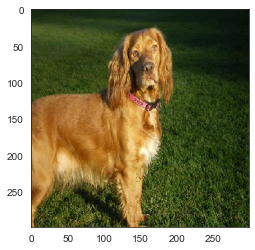

In [42]:
# Sanity check to see if above code worked

plt.imshow(x_train[1].astype('uint8'))
print(filtered_breeds[np.argmax(y_train[1])])

In [43]:
# This line of code is to delete images and free up memory

del images
gc.collect()

83221

In [44]:
# Importing the InceptionV3 model same as previous model

pre_trained_model =  InceptionV3(weights = "imagenet", input_shape=(299,299,3), include_top= False)

for layer in pre_trained_model.layers:
    layer.trainable=False
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [45]:
# Setting last output layer as mixed9

last_layer = pre_trained_model.get_layer('mixed9')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 8, 8, 2048)


In [46]:
# Setting a Callback to stop running model at 80% accuracy

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.80):
      print("\nReached 80.0% accuracy so cancelling training!")
      self.model.stop_training = True

In [47]:
# Setting up the model

model = Sequential()
model.add(pre_trained_model)
model.add(GlobalAveragePooling2D())
model.add(layers.Flatten()) 
model.add(layers.Dropout(0.3))
model.add(Dense(2048, activation = 'relu'))
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(len(filtered_breeds), activation = 'softmax'))

model.compile(optimizer = RMSprop(lr=0.001), loss ='categorical_crossentropy', metrics =['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 512)              

In [48]:
# Data Augmentation on the model

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True
)

train_generator = train_datagen.flow(x_train, y_train,shuffle = False, batch_size = 25)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator =  val_datagen.flow(x_val, y_val, shuffle = False, batch_size = 25)

In [49]:
# Running the model

callbacks = myCallback()

epochs = 40
history = model.fit_generator(train_generator,epochs=epochs,validation_data=validation_generator,callbacks=[callbacks])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
79/79 [==============================] - 103s 1s/step - loss: 4.7518 - accuracy: 0.0526 - val_loss: 3.6190 - val_accuracy: 0.1929
Epoch 2/40
79/79 [==============================] - 105s 1s/step - loss: 2.7985 - accuracy: 0.3337 - val_loss: 1.5014 - val_accuracy: 0.5607
Epoch 3/40
79/79 [==============================] - 112s 1s/step - loss: 1.7152 - accuracy: 0.5128 - val_loss: 1.1850 - val_accuracy: 0.6214
Epoch 4/40
79/79 [==============================] - 116s 1s/step - loss: 1.3884 - accuracy: 0.6051 - val_loss: 1.1315 - val_accuracy: 0.6643
Epoch 5/40
79/79 [==============================] - 116s 1s/step - loss: 1.2258 - accuracy: 0.6490 - val_loss: 1.0509 - val_accuracy: 0.6917
Epoch 6/40
79/79 [==============================] - 103s 1s/step - loss: 1.1391 - accuracy: 0.6612 - val_loss: 0.8614 - val_accuracy: 0.7381
Epoch 7/40
79/79 [==============================] - 113s 1s/step - loss: 1.066

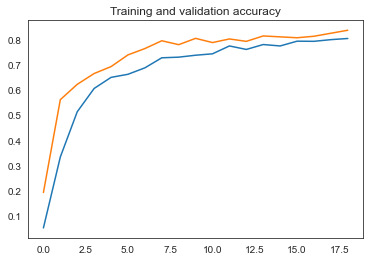

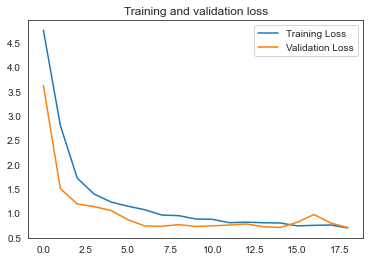

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.savefig('Images/FinalModelAccuracy.png', bbox_inches = "tight")

plt.figure()

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('Images/FinalModelLoss.png', bbox_inches = "tight")

plt.show()


In [51]:
test_generator = train_datagen.flow(x_test, y_test,shuffle = False, batch_size = 25)

print(f"\nTraining Score: {model.evaluate(train_generator)}")
print(f"\nValidation Score: {model.evaluate(validation_generator)}")
print(f"\nTest Score: {model.evaluate(test_generator)}")

79/79 [==============================] - 80s 1s/step - loss: 0.5061 - accuracy: 0.8505

Training Score: [0.5061443448066711, 0.8505101799964905]
34/34 [==============================] - 30s 886ms/step - loss: 0.7001 - accuracy: 0.8357

Validation Score: [0.7000744938850403, 0.8357142806053162]
48/48 [==============================] - 51s 1s/step - loss: 1.3400 - accuracy: 0.7067

Test Score: [1.339979887008667, 0.7066666483879089]


In [52]:
model.save("Model/")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Model/assets


- The Model was able to reach the 81% training accuracy score, had a validation accuracy score of about 82%, and a test accuracy score of about 70%.  This score might have been higher if I didn't set the training accuracy score threshold at 80%. May go back to change that at a later date.  Overall it has done very well.  This model also doesn't seem to have the underfitting problem of the previous model.  This could be perhaps this model having a smaller data set with more augmentations.

## 4. B Prediction Samples

German_shepherd


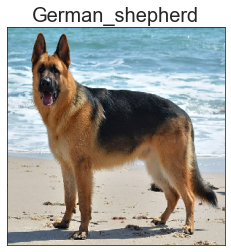

In [28]:
img_path = ("TestImages/German_Shepherd.jpg")

img = image.load_img(img_path, target_size=(299, 299))

img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

img_preprocessed = preprocess_input(img_batch)

plt.imshow(img)
plt.title(filtered_breeds[np.argmax(model.predict(img_preprocessed))], size = 20)
plt.xticks([])
plt.yticks([])

print(filtered_breeds[np.argmax(model.predict(img_preprocessed))])
plt.savefig('Images/GermanShepherdPrediction.png', bbox_inches = "tight")

- Able to correctly identify a picture of a German Shepherd

miniature_poodle


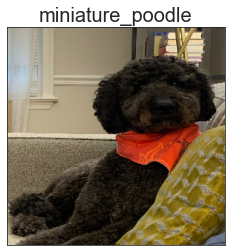

In [29]:
img_path = ("TestImages/Guillermo.jpg")

img = image.load_img(img_path, target_size=(299, 299))

img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

img_preprocessed = preprocess_input(img_batch)

plt.imshow(img)
plt.title(filtered_breeds[np.argmax(model.predict(img_preprocessed))], size = 20)
plt.xticks([])
plt.yticks([])

print(filtered_breeds[np.argmax(model.predict(img_preprocessed))])
plt.savefig('Images/ZukoPrediction.png', bbox_inches = "tight")

- Able to partially identify a Labradoodle which is a Standard Poodle Labrador mix by labeling it a miniature poodle

Border_collie


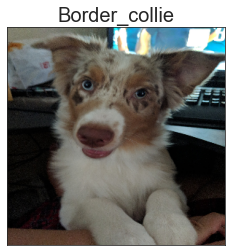

In [30]:
img_path = ("TestImages/MVIMG_20180916_133030.jpg")

img = image.load_img(img_path, target_size=(299, 299))

img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

img_preprocessed = preprocess_input(img_batch)

plt.imshow(img)
plt.title(filtered_breeds[np.argmax(model.predict(img_preprocessed))], size = 20)
plt.xticks([])
plt.yticks([])

print(filtered_breeds[np.argmax(model.predict(img_preprocessed))])
plt.savefig('Images/GingerPrediction.png', bbox_inches = "tight")

- Able to identify a Australian Shepherd as one of it closest breed neighbors a Border Collie

Shetland_sheepdog


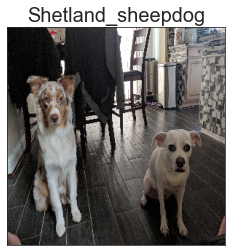

In [31]:
img_path = ("TestImages/IMG_20181102_144409.jpg")

img = image.load_img(img_path, target_size=(299, 299))

img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

img_preprocessed = preprocess_input(img_batch)

plt.imshow(img)
plt.title(filtered_breeds[np.argmax(model.predict(img_preprocessed))], size = 20)
plt.xticks([])
plt.yticks([])

print(filtered_breeds[np.argmax(model.predict(img_preprocessed))])
plt.savefig('Images/TwoDogPrediction.png', bbox_inches = "tight")

- With two dog images it seems to identify the large of the two dogs which is and Australian Shepherd but the coloring cause the model to classify it as a Shetland_sheepdog

French_bulldog


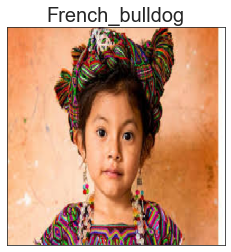

In [32]:
img_path = ("TestImages/girl.jpg")

img = image.load_img(img_path, target_size=(299, 299))

img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

img_preprocessed = preprocess_input(img_batch)

plt.imshow(img)
plt.title(filtered_breeds[np.argmax(model.predict(img_preprocessed))], size = 20)
plt.xticks([])
plt.yticks([])

print(filtered_breeds[np.argmax(model.predict(img_preprocessed))])
plt.savefig('Images/Girl.png', bbox_inches = "tight")

- Test it for fun and the picture of a girl was identified as a French Bull dog

# 5 Conclusion

- The best model was formed after research was done on how hard classifying 120 labels are by trying to do the iterative approach which didn't allow the model to score over a 20% on the accuracy score.  By adding tranfer learning done with the InceptionV3 tranfer learning model the score was greatly increased to viable bounds.  The final model itself performed very well having a 81% training accuracy, 82% Validation accuracy, and a 70% test accuracy score.  The score itself may have increased if the model was allowed to run in totality instead of cancelling the training once the 80% training accuracy threshold was met.  Ran some prediction on the Model with images outside of the dataset and it performed rather well.

## 5. A Limitations

1. The amount of dog breeds was limited to the 120 breeds that were given in the data.  The AKC currently classifies 197 dog breeds which mean currently the data is missing over 70+ dog breeds.
2. The data itself is quite old where the dataset was made back in 2011.  Although the dataset was compiled in 2011 some of the images date even further back considering some of the items contained in the images and the image quality.
3. None of the images include any dogs in their puppy stages.  All the images only included dogs that were of adult age.

## 5. B Next Steps

1. The first step would be add data on the remaining dog breeds that are missing to include the most inclusive training data set possible.
2. Break down the Dogs into percentage classification because more than likely dogs that end up a the shelter are mixed breeds.  Having a percentage break down would be more useful than having a single classifier.
3.  Try to tune this models to work with other species of animals such as cats and birds which are other animals that are surrendered to shelters.